In [1]:
import os
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import random
from sklearn.model_selection import train_test_split
# import rioxarray as rxr
# import earthpy.plot as ep
# import cartopy.crs as ccrs

In [2]:
def scaleCCMinMax(x):
    return(x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

### Read in all data & Visual check & Convert to table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


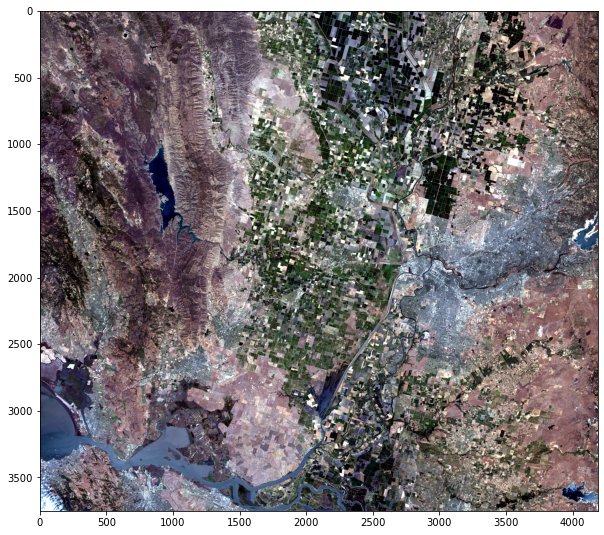

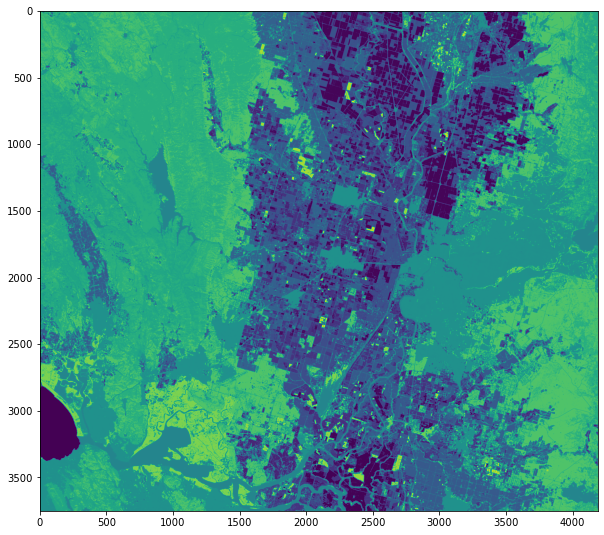

(3751, 4188, 9)
(9, 4188, 3751)
(15709188, 9)


In [3]:
raster_dir = '../data/Data'

for file in os.listdir(raster_dir):
    if file.endswith('SRB1_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        CAerosol = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB2_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        BLUE = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB3_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        GREEN = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB4_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        RED = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB5_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        NIR = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB6_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR1 = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB7_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR2 = raster.GetRasterBand(1).ReadAsArray()/10000

groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'
raster = gdal.Open(groundTruth_path)
groundTruth = raster.GetRasterBand(1).ReadAsArray()
        
raster_array = np.dstack((CAerosol, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, groundTruth, groundTruth))
Image_Pre_Check = np.dstack((scaleCCMinMax(raster_array[:, :, 3]), scaleCCMinMax(raster_array[:, :, 2]), scaleCCMinMax(raster_array[:, :, 1])))
plt.figure(figsize=(10, 10))
plt.imshow(Image_Pre_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(raster_array[:, :, 7])
plt.show()

print(raster_array.shape)

raster_array_t = raster_array.transpose()
print(raster_array_t.shape)

raster_array_table = raster_array_t.reshape(raster_array_t.shape[0], (raster_array_t.shape[1]*raster_array_t.shape[2])).transpose()
print(raster_array_table.shape)

### Prepare Training label

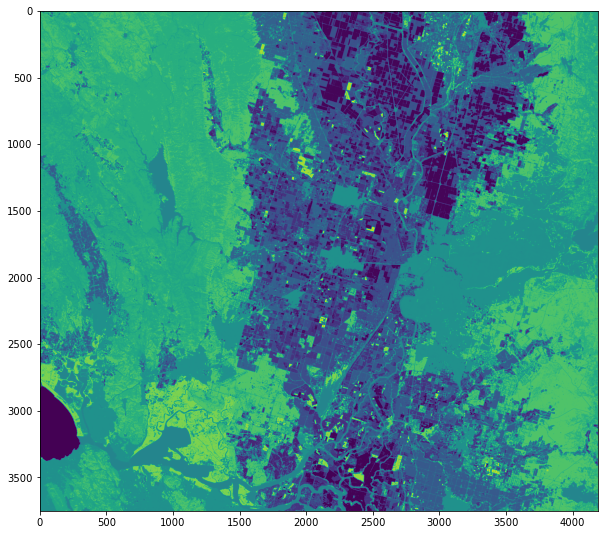

(3751, 4188)
(15709188, 1)


In [52]:
# groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'

# raster = gdal.Open(groundTruth_path)
# groundTruth = raster.GetRasterBand(1).ReadAsArray()

# plt.figure(figsize=(10, 10))
# plt.imshow(groundTruth)
# plt.show()

# print(groundTruth.shape)

# groundTruth_table = groundTruth.reshape(1, (groundTruth.shape[0]*groundTruth.shape[1])).transpose()
# print(groundTruth_table.shape)

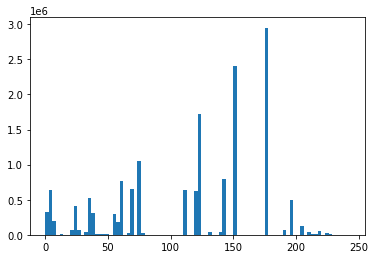

[  0   1   2   3   4   5   6  12  13  14  21  22  23  24  27  28  29  31
  33  36  37  39  42  43  44  46  47  48  49  50  51  53  54  57  58  59
  61  66  67  68  69  70  71  72  74  75  76  77  92 111 112 121 122 123
 124 131 141 142 143 152 176 190 195 204 205 206 208 209 211 212 213 214
 216 217 218 219 220 221 222 224 225 226 227 228 229 236 242 243]
88


In [53]:
# plt.figure()
# plt.hist(groundTruth.flatten(), bins = 86)
# plt.show()

# print(np.unique(groundTruth.flatten()))
# print(len(np.unique(groundTruth.flatten())))

In [35]:
groundTruth_df = pd.DataFrame(raster_array_table[:, 7])
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

table['groundType'] = ['Water', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'unflower', 'Sweet Corn', 'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Rye', 'Oats', 'Millet', 'Canola', 'Safflower', 'Alfalfa', 
                       'Other Hay/Non Alfalfa', 'Buckwheat', 'Sugarbeets', 'Botatoes', 'Other Crops', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Peas', 'Tomatoes', 'Herbs', 'Clover/Wildflowers', 
                       'Sod/grass Seed', 'Fllow/Idle Cropland', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 
                       'Developed/Open Space', 'Developed/Low Intensity', 'Developed/Med Intensity', 'Developed/High Intensity', 'Barren', 'Decodipis Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland', 'Grassland/Pasture', 'Woody Wetlands', 
                       'Herbaceous Wetlands', 'Pistachios', 'Triticale', 'Carrots', 'Garlic', 'Cantaloupes', 'Olives', 'Oranges', 'Honeydew Meions', 'Broccoli', 'Peppers', 'Pomegranates', 'Nectarines', 'Greens', 'Plums', 'Strawberries', 'Squash', 'Vetch', 
                       'Dbl Crop WinWht/Corn', 'Dbi Crop Oats/Corn', 'Lettuce', 'Dbl Crop Triticale/Corn', 'Pumpkins', 'Dbl Crop Winwht/Sorghum', 'Blueberries', 'Cabbage']
table['reclassify'] = ['Water', 'Corn', 'Other Crops', 'Rice', 'Wheat', 'GroundVege', 'Flower', 'Corn', 'Corn', 'Alfalfa', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Flower', 'Flower', 'Alfalfa', 'Hay', 'Wheat', 'Tuber', 'Tuber', 'Other Crops', 'Tuber', 
                       'Other Crops', 'GroundVege', 'GroundVege', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege', 'Alfalfa', 'Flower', 'Grassland', 'Idle cropland', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'Grapes', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'NutTree', 
                       'NutTree', 'NutTree', 'FruitsTree', 'Water', 'Water', 'Water', 'Urban', 'Urban', 'Urban', 'Urban', 'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Grassland', 'Wetland', 'Wetland', 'NutTree', 'Wheat', 'GroundVege', 'GroundVege', 'GroundVege', 
                       'NutTree', 'FruitsTree', 'GroundVege', 'GroundVege', 'GroundVege', 'FruitsTree', 'FruitsTree', 'GroundVege', 'FruitsTree', 'Other Crops', 'GroundVege', 'Flower', 'Corn', 'Corn', 'GroundVege', 'Corn', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege']
table['Value_20'] = [2, 18, 20, 17, 16, 12, 15, 18, 18, 14, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 6, 16, 13, 13, 20, 13, 20, 12, 12, 12, 16, 12, 12, 14, 15, 5, 19, 10, 10, 10, 9, 10, 10, 10, 11, 11, 11, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 11, 
                     16, 12, 12, 12, 11, 10, 12, 12, 12, 10, 10, 12, 10, 20, 12, 15, 18, 18, 12, 18, 12, 16, 12, 12]
table['Value_12'] = [2, 11, 11, 11, 11, 9, 9, 11, 11, 9, 11, 11, 11, 11, 11, 11, 11, 9, 9, 9, 6, 11, 9, 9, 11, 9, 11, 9, 9, 9, 11, 9, 9, 9, 9, 5, 12, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 10, 11, 9, 9, 9, 10, 
                     10, 9, 9, 9, 10, 10, 9, 10, 11, 9, 9, 11, 11, 9, 11, 9, 11, 9, 9]

table.to_csv('../data/GroundTruth/LandCover.csv')
table

ValueError: Length of values (88) does not match length of index (20)

In [5]:
for index, row in table.iterrows():
    raster_array_table[:, 7][raster_array_table[:, 7] == index] = row['Value_20']
    raster_array_table[:, 8][raster_array_table[:, 8] == index] = row['Value_12']
print(np.unique(raster_array_table[:, 7].flatten()))
print(len(np.unique(raster_array_table[:, 7].flatten())))
print(np.unique(raster_array_table[:, 8].flatten()))
print(len(np.unique(raster_array_table[:, 8].flatten())))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
20
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
12


In [9]:
15709188*0.05

785459.4

In [10]:
reclass_20_table = pd.DataFrame(pd.DataFrame(raster_array_table[:, 7]).groupby([0]).size())
reclass_20_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']

reclass_20_table['percentile'] = reclass_20_table[0] / np.sum(reclass_20_table[0])

print(np.sum(reclass_20_table['percentile']))
reclass_20_table['sample_size'] = np.round(reclass_20_table['percentile'] * 785460)
print(np.sum(reclass_20_table['sample_size']))
reclass_20_table

1.0
785458.0


0          Class  percentile  sample_size
0                                                    
1.0     41254         Barren    0.002626       2063.0
2.0    644420          Water    0.041022      32221.0
3.0   2347088          Urban    0.149409     117354.0
4.0    565302        Wetland    0.035985      28265.0
5.0   2950765      Grassland    0.187837     147538.0
6.0    308647            Hay    0.019648      15432.0
7.0   2410539      Shrubland    0.153448     120527.0
8.0    831074         Forest    0.052904      41554.0
9.0    644888         Grapes    0.041052      32244.0
10.0   115825     FruitsTree    0.007373       5791.0
11.0  1107766        NutTree    0.070517      55388.0
12.0   338271     GroundVege    0.021533      16914.0
13.0    17529          Tuber    0.001116        876.0
14.0   522879        Alfalfa    0.033285      26144.0
15.0   432938         Flower    0.027560      21647.0
16.0   654523          Wheat    0.041665      32726.0
17.0   631669           Rice    0.040210      31583.0
18.0   241755           Corn    0.015389      12088.0
19.0   771604  Idle cropland    0.049118      38580.0
20.0   130452    Other Crops    0.008304       6523.0

In [11]:
reclass_12_table = pd.DataFrame(pd.DataFrame(raster_array_table[:, 8]).groupby([0]).size())
reclass_12_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Plant', 'Tree', 'Crop', 'Idle cropland']

reclass_12_table['percentile'] = reclass_12_table[0] / np.sum(reclass_12_table[0])

print(np.sum(reclass_12_table['percentile']))
reclass_12_table['sample_size'] = np.round(reclass_12_table['percentile'] * 785460)
print(np.sum(reclass_12_table['sample_size']))
reclass_12_table

0.9999999999999998
785459.0


0          Class  percentile  sample_size
0                                                    
1.0     41254         Barren    0.002626       2063.0
2.0    644420          Water    0.041022      32221.0
3.0   2347088          Urban    0.149409     117354.0
4.0    565302        Wetland    0.035985      28265.0
5.0   2950765      Grassland    0.187837     147538.0
6.0    308647            Hay    0.019648      15432.0
7.0   2410539      Shrubland    0.153448     120527.0
8.0    831074         Forest    0.052904      41554.0
9.0   1956516          Plant    0.124546      97826.0
10.0  1223591           Tree    0.077890      61180.0
11.0  1658388           Crop    0.105568      82919.0
12.0   771604  Idle cropland    0.049118      38580.0

### Prepare data for 20 classes

In [14]:
groundTruth_table = pd.DataFrame(raster_array_table[:, 7])
label_index = []
for index, row in reclass_20_table.iterrows():
    label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

data = raster_array_table[label_index, 0:7]
print('Training data input shape: ' + str(data.shape))
label = raster_array_table[label_index, 7]
print('Training data label shape: ' + str(label.shape))

x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

print('Training data input shape: ' + str(x_train.shape))
print('Training data label shape: ' + str(y_train.shape))
print('Testing data input shape: ' + str(x_test.shape))
print('Testing data label shape: ' + str(y_test.shape))

Random selected label index shape: (785458, 1)
Training data input shape: (785458, 7)
Training data label shape: (785458,)
Training data input shape: (526256, 7)
Training data label shape: (526256,)
Testing data input shape: (259202, 7)
Testing data label shape: (259202,)


### Prepare data for 12 classes

In [99]:
# groundTruth_table = pd.DataFrame(raster_array_table[:, 8])
# label_index = []
# for index, row in reclass_12_table.iterrows():
#     label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
# print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

# data = raster_array_table[label_index, 0:7]
# print('Training data input shape: ' + str(data.shape))
# label = raster_array_table[label_index, 8]
# print('Training data label shape: ' + str(label.shape))

# x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

# print('Training data input shape: ' + str(x_train.shape))
# print('Training data label shape: ' + str(y_train.shape))
# print('Testing data input shape: ' + str(x_test.shape))
# print('Testing data label shape: ' + str(y_test.shape))

Random selected label index shape: (470012, 1)
Training data input shape: (470012, 7)
Training data label shape: (470012,)
Training data input shape: (314908, 7)
Training data label shape: (314908,)
Testing data input shape: (155104, 7)
Testing data label shape: (155104,)


### Apply Machine Learning Method

In [24]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##confusion matrix libraries 
from sklearn.metrics import confusion_matrix
from daze import plot_confusion_matrix

### Random Forest Model

In [16]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

pred = rfc.predict(x_test)
print(metrics.classification_report(pred,y_test))

              precision    recall  f1-score   support

         1.0       0.06      0.68      0.10        56
         2.0       0.85      0.91      0.88     10120
         3.0       0.78      0.70      0.74     43255
         4.0       0.36      0.56      0.44      6069
         5.0       0.76      0.65      0.70     57420
         6.0       0.11      0.40      0.17      1367
         7.0       0.71      0.61      0.66     45962
         8.0       0.61      0.67      0.64     12256
         9.0       0.59      0.53      0.56     11635
        10.0       0.05      0.52      0.10       191
        11.0       0.58      0.50      0.54     21270
        12.0       0.63      0.73      0.68      4811
        13.0       0.16      0.59      0.26        80
        14.0       0.45      0.50      0.47      7635
        15.0       0.45      0.57      0.51      5609
        16.0       0.41      0.54      0.46      8197
        17.0       0.79      0.82      0.80     10180
        18.0       0.51    

In [20]:
rfc.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
#fitting tuned model from RandomizedSearchCV
params = {'n_estimators': 250,
  'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': 300,
  'bootstrap': True
  }
rfc_tuned = RandomForestClassifier(**params)
rfc_tuned.fit(x_train, y_train)

pred_tuned = rfc_tuned.predict(x_test)
print(metrics.classification_report(pred_tuned,y_test))

              precision    recall  f1-score   support

         1.0       0.02      0.94      0.05        17
         2.0       0.85      0.91      0.88     10062
         3.0       0.78      0.69      0.73     43627
         4.0       0.35      0.58      0.44      5729
         5.0       0.76      0.64      0.70     58008
         6.0       0.07      0.44      0.12       783
         7.0       0.72      0.61      0.66     46678
         8.0       0.60      0.67      0.64     12141
         9.0       0.58      0.53      0.55     11418
        10.0       0.03      0.77      0.05        61
        11.0       0.59      0.50      0.54     21773
        12.0       0.62      0.72      0.67      4778
        13.0       0.09      0.82      0.17        33
        14.0       0.44      0.50      0.47      7633
        15.0       0.44      0.57      0.50      5435
        16.0       0.39      0.54      0.45      7970
        17.0       0.79      0.81      0.80     10257
        18.0       0.50    

In [ ]:
# rfc = RandomForestClassifier()
# parameters = {'n_estimators': range(30,80,10),'max_depth':range(3,10,2), 'min_samples_leaf':[5,6,7],'max_features':[1,2,3]}

# grid_rfc = GridSearchCV(rfc,parameters,scoring='f1_macro')

# grid_rfc.fit(x_train,y_train)

# grid_rfc.best_params_,grid_rfc.best_score_

In [28]:
pred_rfc = rfc.predict(raster_array_table[:, 0:7])
pred_rfc = np.expand_dims(pred_rfc, axis=1)

raster_array_table = np.append(raster_array_table, pred_rfc, axis=1)
print(raster_array_table)

NameError: name 'y' is not defined

In [33]:
raster_array_table = np.append(raster_array_table, pred_rfc, axis=1)
print(raster_array_table)

[[ 0.0612  0.08    0.1231 ... 11.      1.     11.    ]
 [ 0.0446  0.0624  0.0937 ...  7.      1.      7.    ]
 [ 0.0381  0.0509  0.0782 ...  7.      0.      7.    ]
 ...
 [ 0.0552  0.0739  0.1131 ...  5.      0.      5.    ]
 [ 0.0431  0.061   0.0951 ...  5.      0.      5.    ]
 [ 0.0423  0.0584  0.0927 ...  5.      0.      5.    ]]


In [30]:
raster_array_table = np.append(raster_array_table, np.not_equal(raster_array_table[:, 7], pred_rfc.T).T, axis=1)
raster_array_table

array([[ 0.0612,  0.08  ,  0.1231, ...,  3.    , 11.    ,  1.    ],
       [ 0.0446,  0.0624,  0.0937, ...,  3.    ,  7.    ,  1.    ],
       [ 0.0381,  0.0509,  0.0782, ...,  7.    ,  7.    ,  0.    ],
       ...,
       [ 0.0552,  0.0739,  0.1131, ...,  5.    ,  5.    ,  0.    ],
       [ 0.0431,  0.061 ,  0.0951, ...,  5.    ,  5.    ,  0.    ],
       [ 0.0423,  0.0584,  0.0927, ...,  5.    ,  5.    ,  0.    ]])

In [37]:
pred_rfc_tuned = rfc_tuned.predict(raster_array_table[:, 0:7])
pred_rfc_tuned = np.expand_dims(pred_rfc_tuned, axis=1)

# raster_array_table = np.append(raster_array_table, pred_rfc_tuned, axis=1)
# print(raster_array_table)

In [39]:
raster_array_table = np.append(raster_array_table, pred_rfc_tuned, axis=1)
print(raster_array_table)

[[ 0.0612  0.08    0.1231 ...  1.     11.     11.    ]
 [ 0.0446  0.0624  0.0937 ...  1.      7.      7.    ]
 [ 0.0381  0.0509  0.0782 ...  0.      7.      7.    ]
 ...
 [ 0.0552  0.0739  0.1131 ...  0.      5.      5.    ]
 [ 0.0431  0.061   0.0951 ...  0.      5.      5.    ]
 [ 0.0423  0.0584  0.0927 ...  0.      5.      5.    ]]


In [40]:
raster_array_table = np.append(raster_array_table, np.not_equal(raster_array_table[:, 7], pred_rfc_tuned.T).T, axis=1)
raster_array_table
# np.equal(raster_array_table[:, 7], pred_rfc.T).shape

array([[ 0.0612,  0.08  ,  0.1231, ..., 11.    , 11.    ,  1.    ],
       [ 0.0446,  0.0624,  0.0937, ...,  7.    ,  7.    ,  1.    ],
       [ 0.0381,  0.0509,  0.0782, ...,  7.    ,  7.    ,  0.    ],
       ...,
       [ 0.0552,  0.0739,  0.1131, ...,  5.    ,  5.    ,  0.    ],
       [ 0.0431,  0.061 ,  0.0951, ...,  5.    ,  5.    ,  0.    ],
       [ 0.0423,  0.0584,  0.0927, ...,  5.    ,  5.    ,  0.    ]])

In [41]:
raster_array_table.shape

(15709188, 14)

In [133]:
# raster_array_table[:, 10] = np.not_equal(raster_array_table[:, 8], pred_rfc.T)
# raster_array_table

array([[0.0612, 0.08  , 0.1231, ..., 3.    , 9.    , 1.    ],
       [0.0446, 0.0624, 0.0937, ..., 3.    , 7.    , 1.    ],
       [0.0381, 0.0509, 0.0782, ..., 7.    , 7.    , 0.    ],
       ...,
       [0.0552, 0.0739, 0.1131, ..., 5.    , 5.    , 0.    ],
       [0.0431, 0.061 , 0.0951, ..., 5.    , 5.    , 0.    ],
       [0.0423, 0.0584, 0.0927, ..., 5.    , 5.    , 0.    ]])

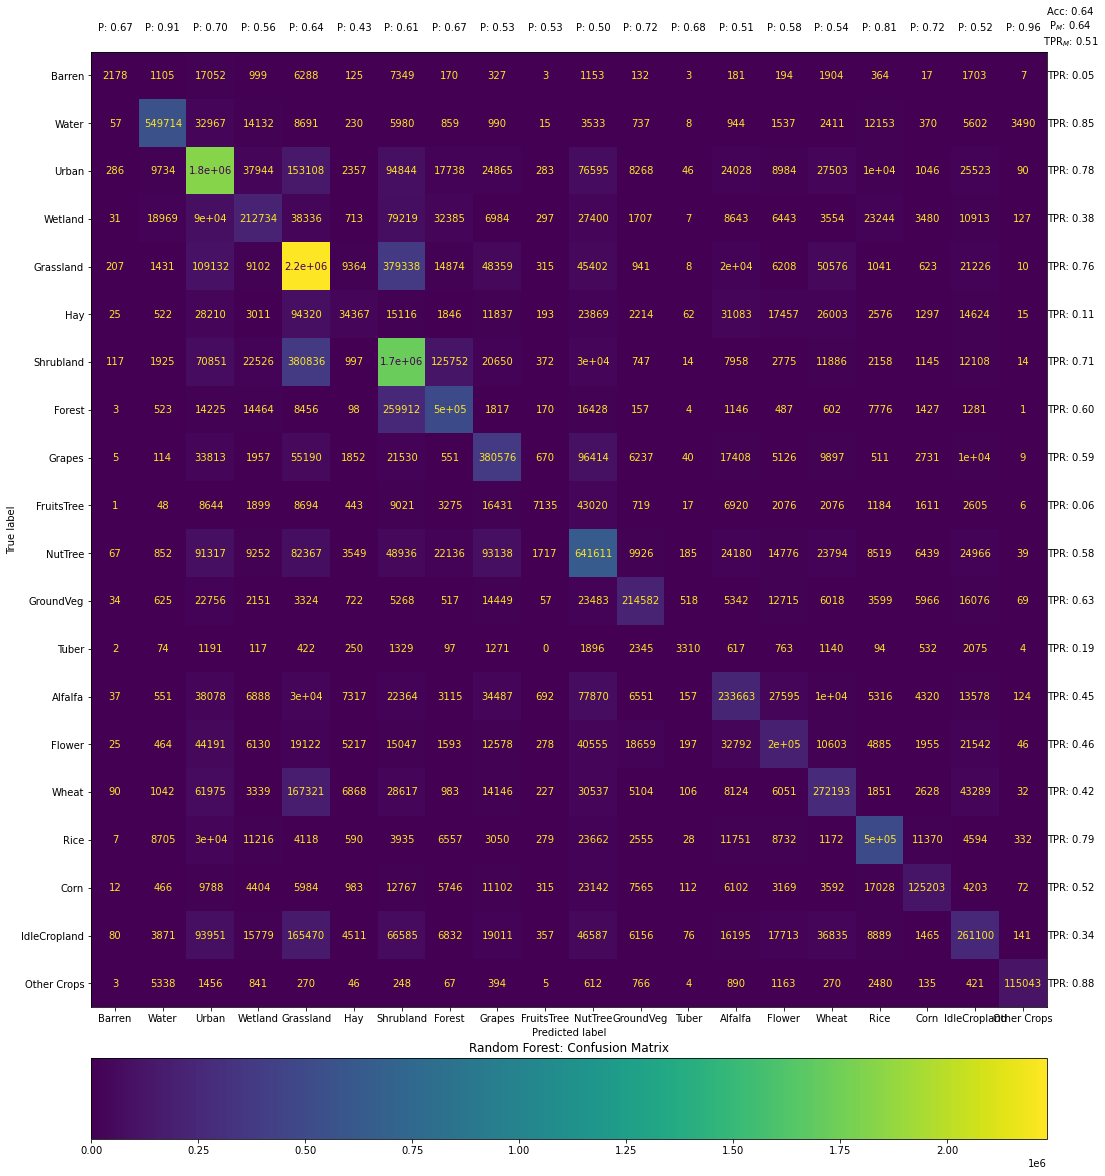

In [42]:
#Plotting Confusion Matrix (predicted on X test)
classes = ('Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVeg', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'IdleCropland', 'Other Crops')
fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(raster_array_table[:, 7], pred_rfc)
plot_confusion_matrix(cm, measures=('a', 'p', 'tpr'), display_labels= classes, measures_format='.2f', ax=ax)
plt.title('Random Forest: Confusion Matrix')
plt.show()

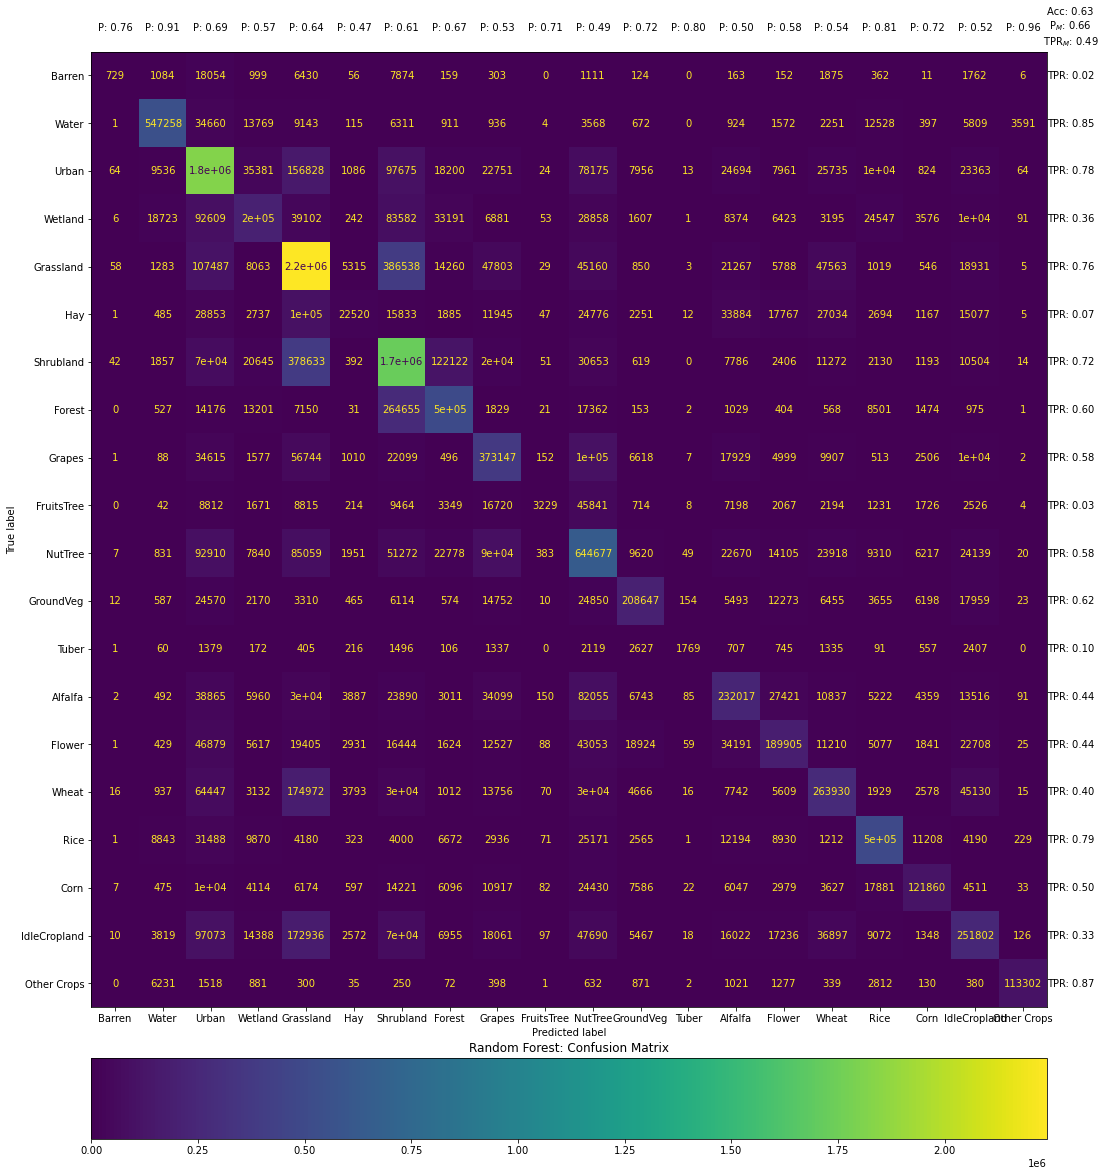

In [43]:
#Plotting Confusion Matrix based on entire dataset
classes = ('Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVeg', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'IdleCropland', 'Other Crops')
fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(raster_array_table[:, 7], pred_rfc_tuned)
plot_confusion_matrix(cm, measures=('a', 'p', 'tpr'), display_labels= classes, measures_format='.2f', ax=ax)
plt.title('Random Forest: Confusion Matrix')

plt.show()

### SVM Model

In [ ]:
# Train SVC model
clf = svm.LinearSVC(C = 1.0)
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)
accuracy_score(y_test, pred_clf)

In [ ]:
pred_clf = rfc.predict(raster_array_table[:, 0:7])
pred_clf = np.expand_dims(pred_clf, axis=1)
print(pred_clf.shape)
raster_array_table = np.append(raster_array_table, pred_clf, axis=1)
print(raster_array_table)

### Convert prediction back to raster and visual check

(14, 15709188)
(14, 4188, 3751)
(3751, 4188, 14)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


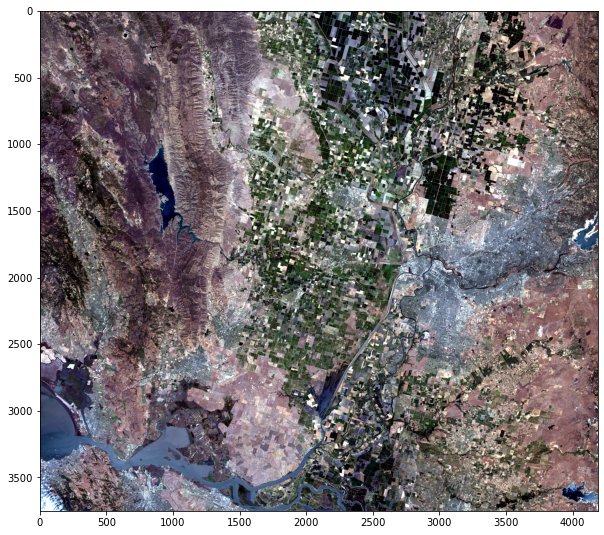

In [44]:
result_array_t = raster_array_table.transpose()
print(result_array_t.shape)

result_array = result_array_t.reshape(result_array_t.shape[0], raster_array_t.shape[1], raster_array_t.shape[2])
print(result_array.shape)

result = result_array.transpose()
print(result.shape)

Result_Check = np.dstack((scaleCCMinMax(result[:, :, 3]), scaleCCMinMax(result[:, :, 2]), scaleCCMinMax(result[:, :, 1])))

plt.figure(figsize=(10, 10))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

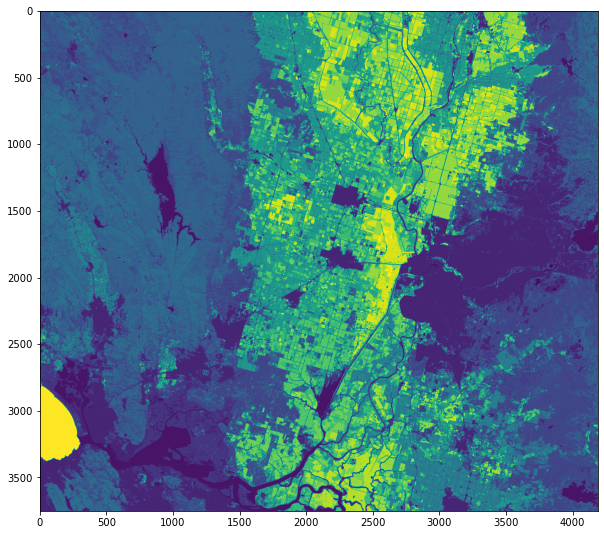

In [45]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 7])
plt.show()

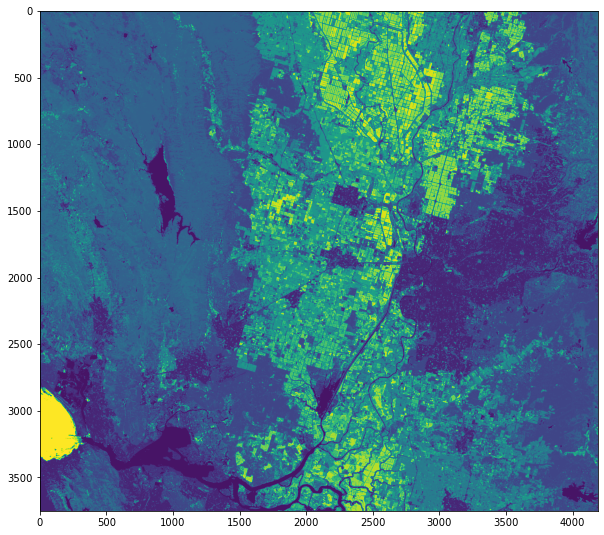

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 9])
plt.show()

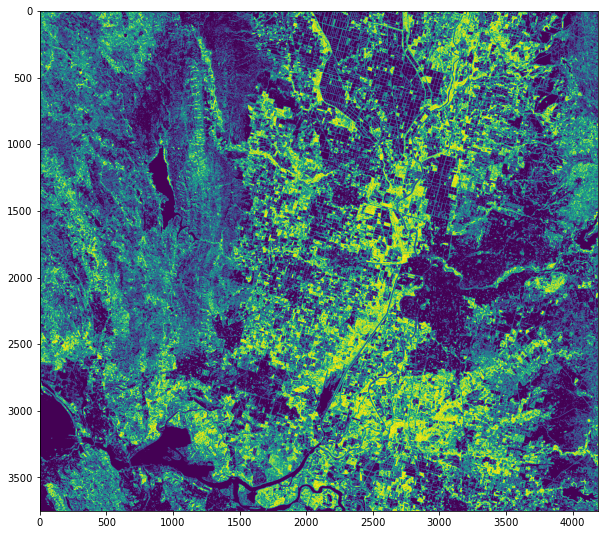

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 10])
plt.show()

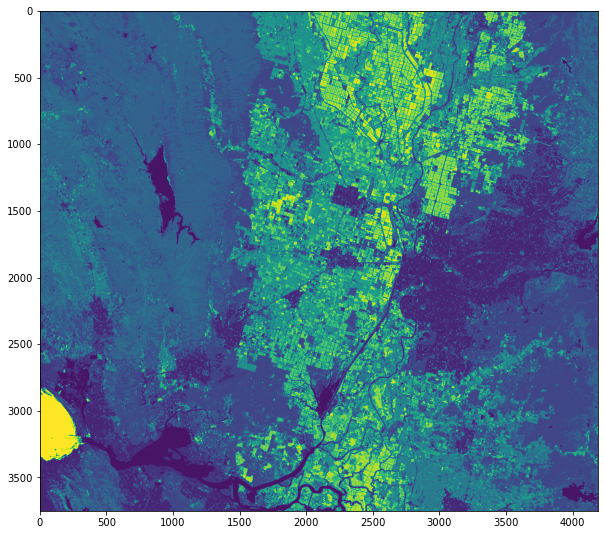

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 12])
plt.show()

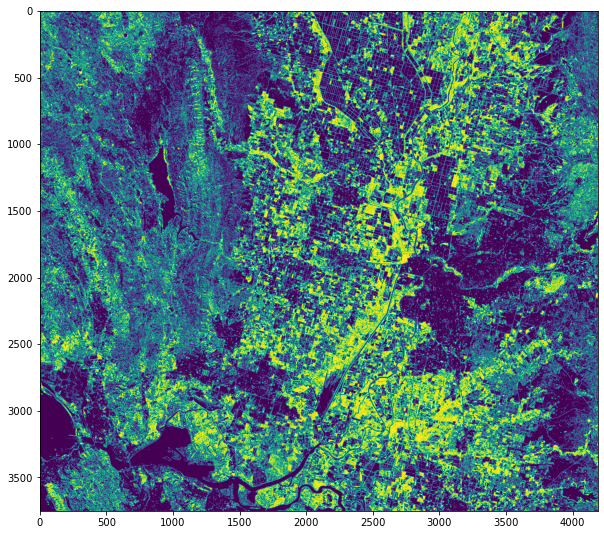

In [49]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 13])
plt.show()

In [ ]:
# print(pred_clf.shape)

# prediction_clf = pred_clf.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
# print(prediction_clf.shape)

# plt.figure(figsize=(10, 10))
# plt.imshow(prediction_clf)
# plt.show()

In [43]:
# class_labels = ['Background', 'Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']
# colors = ['black', 'brown', 'blue', 'purple', 'cyan', 'lime', 'gold', 'green', 'forestgreen', 'seagreen', 'limegreen', 'lawngreen', 'yellowgreen', 'goldenrod', 'springgreen', 'red', 'oragne', 'tomato', 'darkorange', 'peru', 'grey']

# cmap = ListedColormap(colors)

# class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]
# norm = BoundaryNorm(class_bins, len(colors))

# xr.DataArray(prediction, coords=da.coords, dims=da.dims, attrs=da.attrs)

# f, ax = plt.subplots(figsize=(16, 16))
# im = prediction.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# # ep.draw_legend(im, titles=height_class_labels)
# ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
# ax.set_axis_off()
# plt.show()

# C:\Users\YunzZhu\.conda\envs\rangeland\python.exe -I"C:\Users\YunzZhu\.conda\envs\rangeland\Library\include\gdal.h" -lgdal_i -L"C:\Users\YunzZhu\.conda\envs\rangeland\Library\lib\gdal_i.lib" install GDAL-3.0.2-py3.9-win-amd64.egg-info

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 16))

# chm_plot = ax.imshow(lidar_chm,
#                      cmap=cmap,
#                      norm=norm)

# ax.set_title("Lidar Canopy Height Model (CHM)")

# # Add a legend for labels
# legend_labels = {"tan": "short", 
#                  "springgreen": "medium", 
#                  "darkgreen": "tall"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# ax.legend(handles=patches,
#           bbox_to_anchor=(1.35, 1),
#           facecolor="white")

# ax.set_axis_off()
# plt.show()

In [50]:
def array2raster(rasterfn, newRasterfn, array, numBand=1, Float=1):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]

    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = raster.RasterXSize
    rows = raster.RasterYSize

    driver = gdal.GetDriverByName('GTiff')
    ## added by Grace Liu ###
    ## Allowing the choice saving as the Input Data ###
    if Float:
        print(cols, rows, numBand)
        outRaster = driver.Create(newRasterfn, cols, rows, numBand, gdal.GDT_Float32)
    else:
        print(cols, rows, numBand)
        outRaster = driver.Create(newRasterfn, cols, rows, numBand, gdal.GDT_Int16)  # band.DataType)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    if numBand == 1:
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(array)
    elif numBand > 1:
        for i in range(numBand):
            outband = outRaster.GetRasterBand(i + 1)
            outband.WriteArray(array[i, :, :])
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())

In [143]:
# array2raster(groundTruth_path, '../data/GroundTruth/Reclass_20.tif', result[:, :, 7], numBand=1, Float=0)
# array2raster(groundTruth_path, '../data/GroundTruth/Reclass_12.tif', result[:, :, 8], numBand=1, Float=0)

4188 3751 1
4188 3751 1


In [51]:
array2raster(groundTruth_path, '../results/Prediction_20.tif', result[:, :, 9], numBand=1, Float=0)
array2raster(groundTruth_path, '../results/Prediction_20_tuned.tif', result[:, :, 12], numBand=1, Float=0)

4188 3751 1
4188 3751 1


In [52]:
array2raster(groundTruth_path, '../results/Prediction_20_MissClass.tif', result[:, :, 10], numBand=1, Float=0)
array2raster(groundTruth_path, '../results/Prediction_20_MissClass_tuned.tif', result[:, :, 13], numBand=1, Float=0)

4188 3751 1
4188 3751 1
